In [1]:
using Gadfly, DataFrames, DataArrays, Cairo, Images, ImageMagick, RDatasets, MultivariateStats;

    .==(Images.AbstractImageDirect{Bool, N<:Any}, AbstractArray{Bool, N<:Any}) at /Users/cwestrup/.julia/v0.4/Images/src/algorithms.jl:135
is ambiguous with: 
    .==(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /Users/cwestrup/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}})
before the new definition.
    .==(Images.AbstractImageDirect, AbstractArray) at /Users/cwestrup/.julia/v0.4/Images/src/algorithms.jl:136
is ambiguous with: 
    .==(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /Users/cwestrup/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}

In [2]:
set_default_plot_size(25cm, 20cm);

## Data preparation

We can define the feature variables we'll use:

In [3]:
variables = [:fixedAcidity, :volatileAcidity, :citricAcid, :residualSugar, :chlorides, 
    :freeSulfurDioxide, :totalSulfurDioxide, :density, :pH, :sulphates, :alcohol];
length(variables)

11

Read the data into DataFrames

In [4]:
df_submission = readtable("data/challenge_public_test_classification_regression_2015.csv", );

In [5]:
df_train = readtable("data/training_classification_regression_2015.csv");

Normalize features:

In [6]:
df_train_norm = deepcopy(df_train)
for variable in variables
    column = df_train_norm[:, variable]
    df_train_norm[:, variable] = (column .- mean(column)) ./ std(column)
end
df_train_norm;

In [7]:
head(df_train_norm, 1)

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality,_type
1,-0.19581148606307708,-0.3386149588803073,0.5430063966089778,1.6899239900642382,-0.12119819492048489,1.9275660835074595,2.2540949093649036,1.0116150901531629,-0.3105996734319634,0.38998483249693666,-0.8034568236260613,4,White


Stack up the features:

In [8]:
df_train_norm_stacked = stack(df_train_norm, variables);

In [9]:
head(df_train_norm_stacked, 1)

,variable,value,quality,_type
1,fixedAcidity,-0.19581148606307708,4,White


Let's take a look at the quick statistics:

In [10]:
describe(df_train_norm)

fixedAcidity
Min      -2.587720325613098



Preparing the data for test / training:

In [11]:
# X = feature DataFrame, Y = target DataFrame
X = df_train_norm[:,1:11]
Y = df_train_norm[:,12:13];

1st Qu.  -0.6093298618574106
Median   -0.19523216632718682
Mean     -7.354117315117037e-16
3rd Qu.  0.34967160136833886
Max      6.558018856444382
NAs      0
NA%      0.0%

volatileAcidity
Min      -1.5822097816677223
1st Qu.  -0.6708764200080285
Median   -0.2824902874997977
Mean     6.252776074688882e-17
3rd Qu.  0.3528561105078901
Max      6.550287265039177
NAs      0
NA%      0.0%

citricAcid
Min      -2.3356266426779646
1st Qu.  -0.48801367680887225
Median   -0.11332857459489003
Mean     7.496225862269057e-17
3rd Qu.  0.5128832944662467
Max      9.444895343260232
NAs      0
NA%      0.0%

residualSugar
Min      -1.0340555974624916
1st Qu.  -0.7992291015063178
Median   -0.4242622846713319
Mean     2.2666313270747194e-16
3rd Qu.  0.5711275092503425
Max      12.491257040978544
NAs      0
NA%      0.0%

chlorides
Min      -1.24585976053904
1st Qu.  -0.5052565556154898
Median   -0.23974712546574586
Mean     3.694822225952521e-17
3rd Qu.  0.13983702563631997
Max      16.443934106197197
N

A function to generate vectors for splitting the dataset for cross validation each vector selects the datapoints for the test set.

## Functions for cross-validation

In [29]:
# data_size: data points / rows in dataset
# folds: number of split vectors to be used for CV folds
# test_size_ratio: percentage of dataset to be in test set
function getCVSplits(data_size=5000, folds=5, test_size_ratio=0.25)
    splits = []
    for k in range(1,folds)
        is_train = shuffle(range(1, data_size) .> floor(n * test_size_ratio))
        push!(splits, is_train)
    end
    return splits
end

getCVSplits (generic function with 4 methods)

A function that splits our dataset with a boolean vector into test and training set:

In [32]:
# splitvectors: boolean vector that selects which entries are in 
#              test/training set, can be obtained using getCVSplits()
function splitDataset(splitvector)
    X_train = X[splitvector,:]
    X_test  = X[!splitvector,:]
    Y_train = Y[splitvector, :]
    Y_test  = Y[!splitvector, :]
    return (X_train, X_test, Y_train, Y_test)
end

splitDataset (generic function with 1 method)

In [34]:
# Split for training and test set
split = getCVSplits(n, 1, 0.25)

# Create dataframes with training and test set:
(X_train, X_test, Y_train, Y_test) = splitDataset(splits[1])

println("Total number of datapoints: ",n)
println("Training set size: ", sum(is_train))
println("Test set size: ", sum(!is_train))

Total number of datapoints: 5000
Training set size: 3750
Test set size: 1250


# Visualizations

## Classification

A placeholder plot we'll use to fill up grids

In [104]:
placeholder = plot(x=[0], y=[0], Guide.xlabel("'placeholder'"));

Plotting all classes for all variables

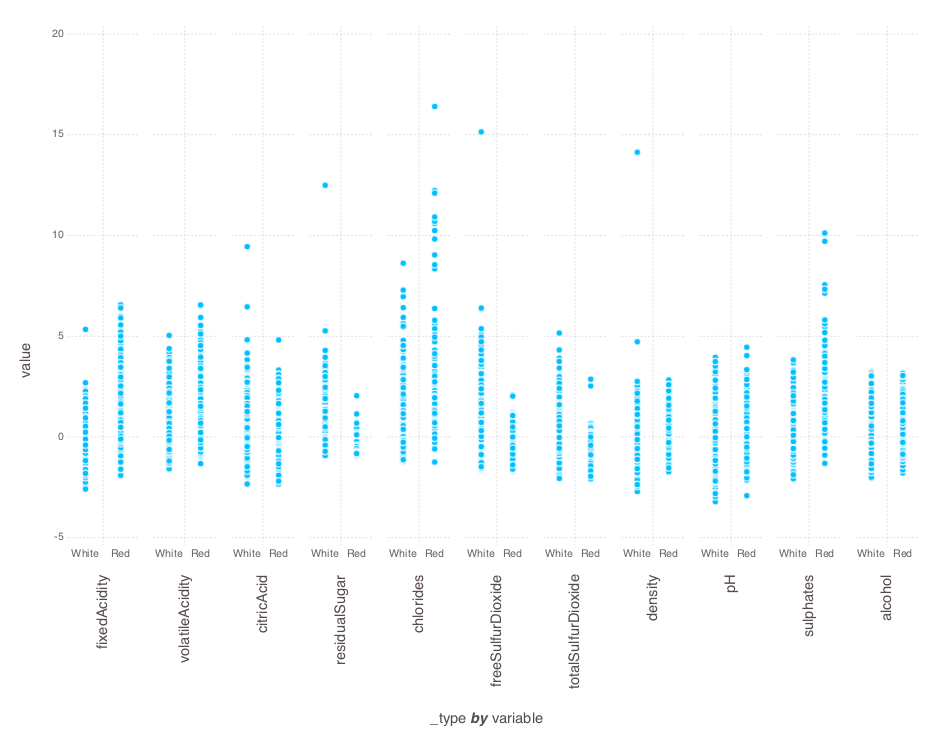

Min      -2.587720325613098
1st Qu.  -0.6093298618574106
Median   -0.19523216632718682
Mean     -7.354117315117037e-16
3rd Qu.  0.34967160136833886
Max      6.558018856444382
NAs      0
NA%      0.0%

volatileAcidity
Min      -1.5822097816677223
1st Qu.  -0.6708764200080285
Median   -0.2824902874997977
Mean     6.252776074688882e-17
3rd Qu.  0.3528561105078901
Max      6.550287265039177
NAs      0
NA%      0.0%

citricAcid
Min      -2.3356266426779646
1st Qu.  -0.48801367680887225
Median   -0.11332857459489003
Mean     7.496225862269057e-17
3rd Qu.  0.5128832944662467
Max      9.444895343260232
NAs      0
NA%      0.0%

residualSugar
Min      -1.0340555974624916
1st Qu.  -0.7992291015063178
Median   -0.4242622846713319
Mean     2.2666313270747194e-16
3rd Qu.  0.5711275092503425
Max      12.491257040978544
NAs      0
NA%      0.0%

chlorides
Min      -1.24585976053904
1st Qu.  -0.5052565556154898
Median   -0.23974712546574586
Mean     3.694822225952521e-17
3rd Qu.  0.13983702563631997
M

In [105]:
filename = "classification_hist_variables"
p = plot(df_train_norm_stacked,
xgroup="variable", x="_type", y="value", Geom.subplot_grid(Geom.point));
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 25cm, 20cm), p)
load(string("plots/", filename, ".png"))

Now each seperately 

In [106]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_train_norm_stacked[df_train_norm_stacked[:variable].==variable, :] 
    push!(plots, plot(feature, x=:_type, y=:value, Geom.point, 
        Guide.xlabel(string(variable), orientation=:horizontal)))
end
push!(plots, placeholder);

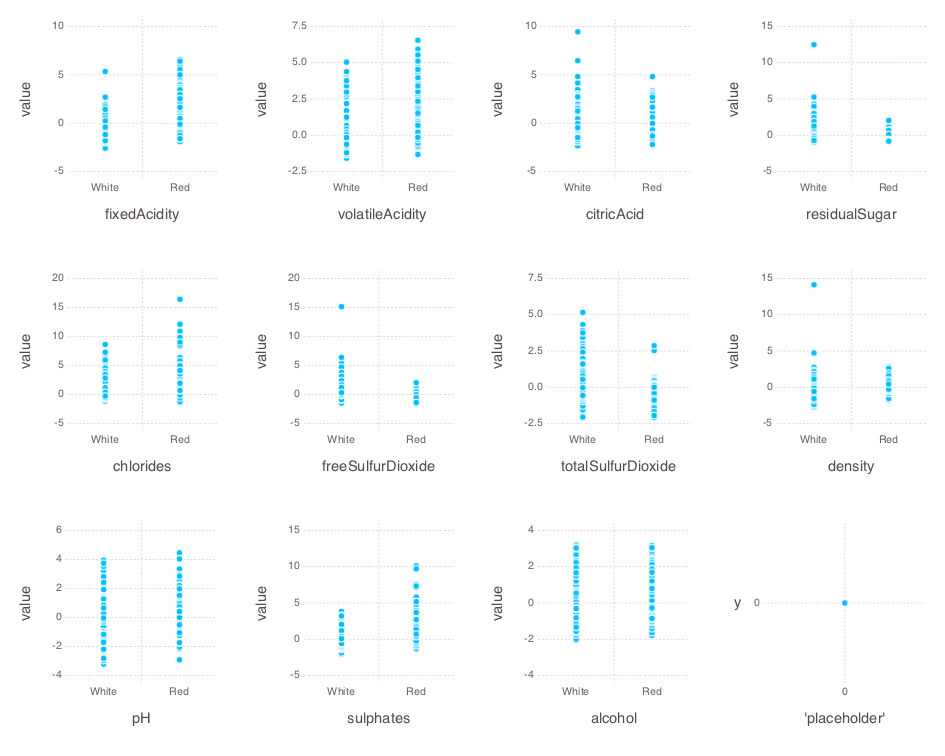

In [107]:
filename = "hist_variables_seperate"

plotstack = vstack(
    hstack(plots[1], plots[2], plots[3], plots[4]),
    hstack(plots[5], plots[6], plots[7], plots[8]),
    hstack(plots[9], plots[10], plots[11], plots[12]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 20cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 20cm), plotstack)
load(string("plots/", filename, ".png"))

The features look somewhat seperable, let's look at the density

In [108]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_train_norm_stacked[df_train_norm_stacked[:variable].==variable, :] 
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

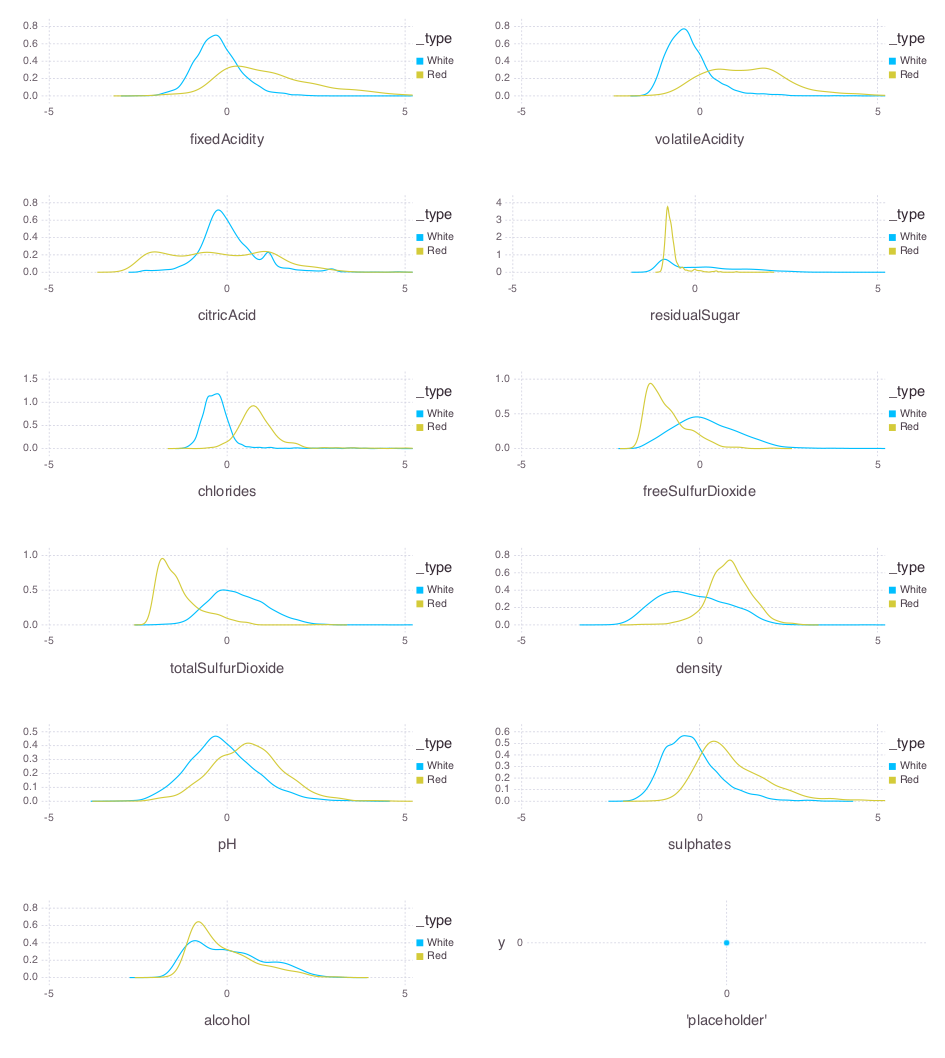

In [109]:
filename = "density_type_seperate"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
imread(string("plots/", filename, ".png"))

Seems like there is some pattern here at least...

TODO: plot the variables in correlation to each other?

In [135]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_train_norm_stacked[df_train_norm_stacked[:variable].==variable, :] 
    
    push!(plots, plot(feature, color=:quality, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

In [136]:
filename = "density_quality_seperate"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
imread(string("plots/", filename, ".png"))

LoadError: LoadError: BoundsError: attempt to access 0-element Array{Any,1}
  at index [1]
while loading In[136], in expression starting on line 2

## PCA

In [112]:
# train a PCA model
X_matrix = Matrix(deepcopy(X))
M = fit(PCA, X_matrix'; maxoutdim=15, method=:auto)
pca_matrix = transform(M, X_matrix')';

In [113]:
# make it a DataFrame and merge it with the labels
df_pca = DataFrame(pca_matrix)
df_pca_labelled = hcat(df_pca, Y)
head(df_pca_labelled,1)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,quality,_type
1,-2.7482606232752134,-2.1260445513600894,0.3373770782171445,0.9575492537102434,0.04013838985184908,0.9017164225546604,0.07271211686422652,0.004219083534487509,-0.182775206760877,0.2667753194288211,4,White


First 2 principal components:

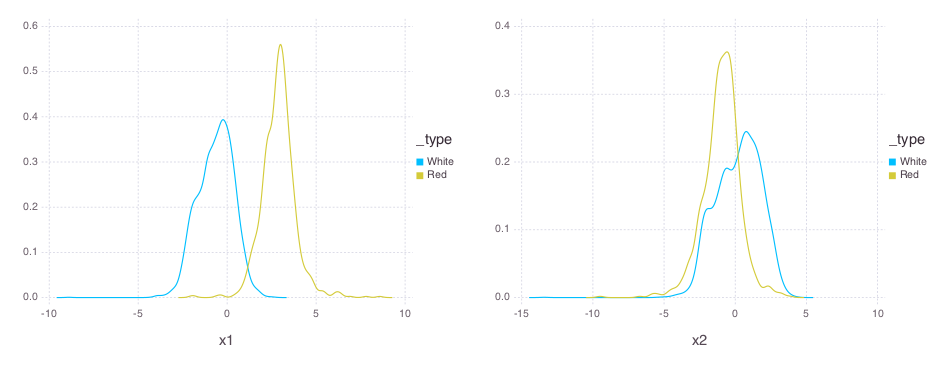

In [114]:
filename = "density_pca"
p1 = plot(df_pca_labelled, color=:_type, x=:x1, Geom.density)
p2 = plot(df_pca_labelled, color=:_type, x=:x2, Geom.density)
plotstack = hstack(p1, p2)

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 10cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 10cm), plotstack)
load(string("plots/", filename, ".png"))

First 2 components on a plane

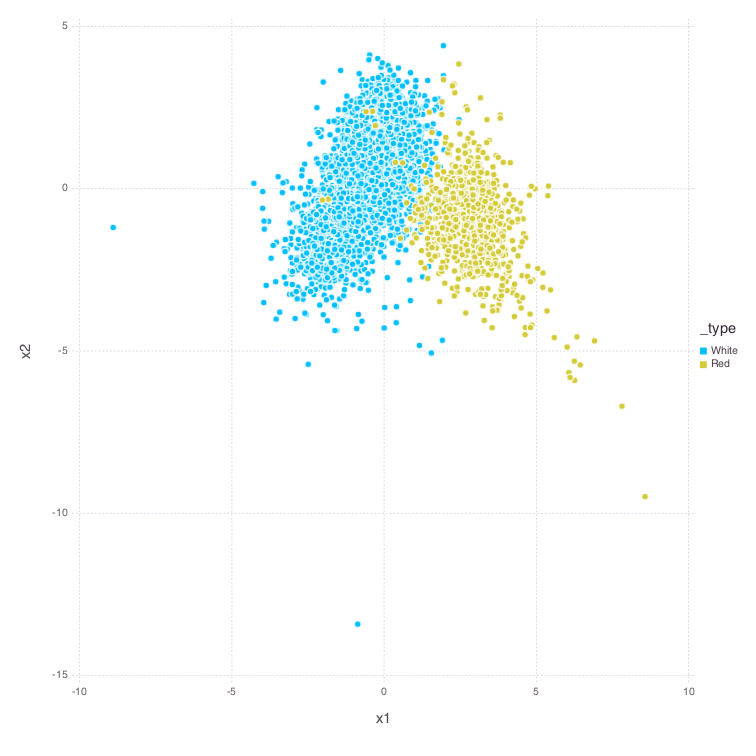

In [115]:
filename = "pca"
p = plot(df_pca_labelled, color=:_type, x=:x1, y=:x2, Geom.point)
draw(PDF(string("plots/", filename, ".pdf"), 20cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 20cm, 20cm), p)
load(string("plots/", filename, ".png"))

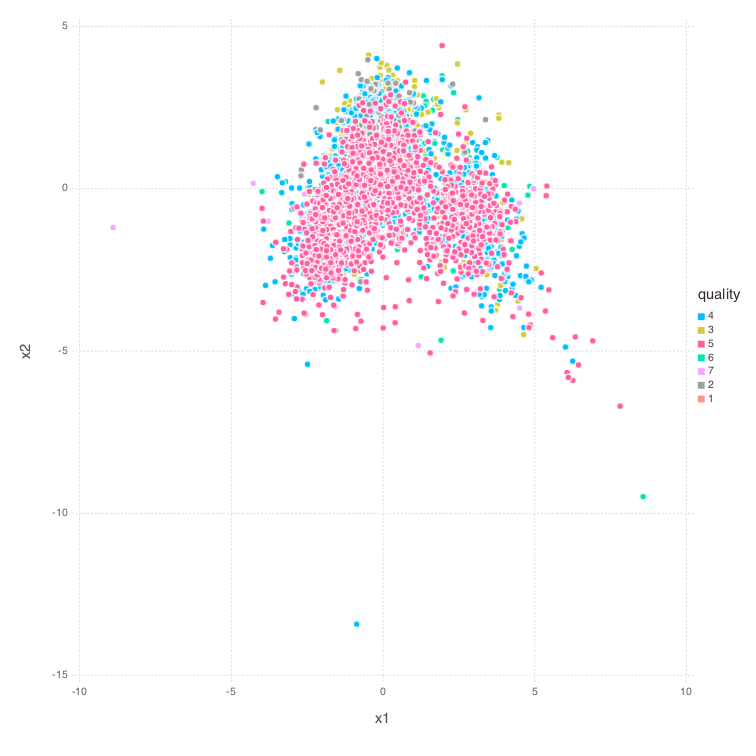

In [116]:
filename = "pca"
p = plot(df_pca_labelled, color=:quality, x=:x1, y=:x2, Geom.point, Scale.color_discrete())
draw(PDF(string("plots/", filename, ".pdf"), 20cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 20cm, 20cm), p)
load(string("plots/", filename, ".png"))

In [117]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6, :x7, :x8, :x9, :x10]
df_pca_labelled_stacked = stack(df_pca_labelled, variables)

for variable in variables
    feature = df_pca_labelled_stacked[df_pca_labelled_stacked[:variable].==variable, :]     
    push!(plots, plot(feature, color=:quality, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end

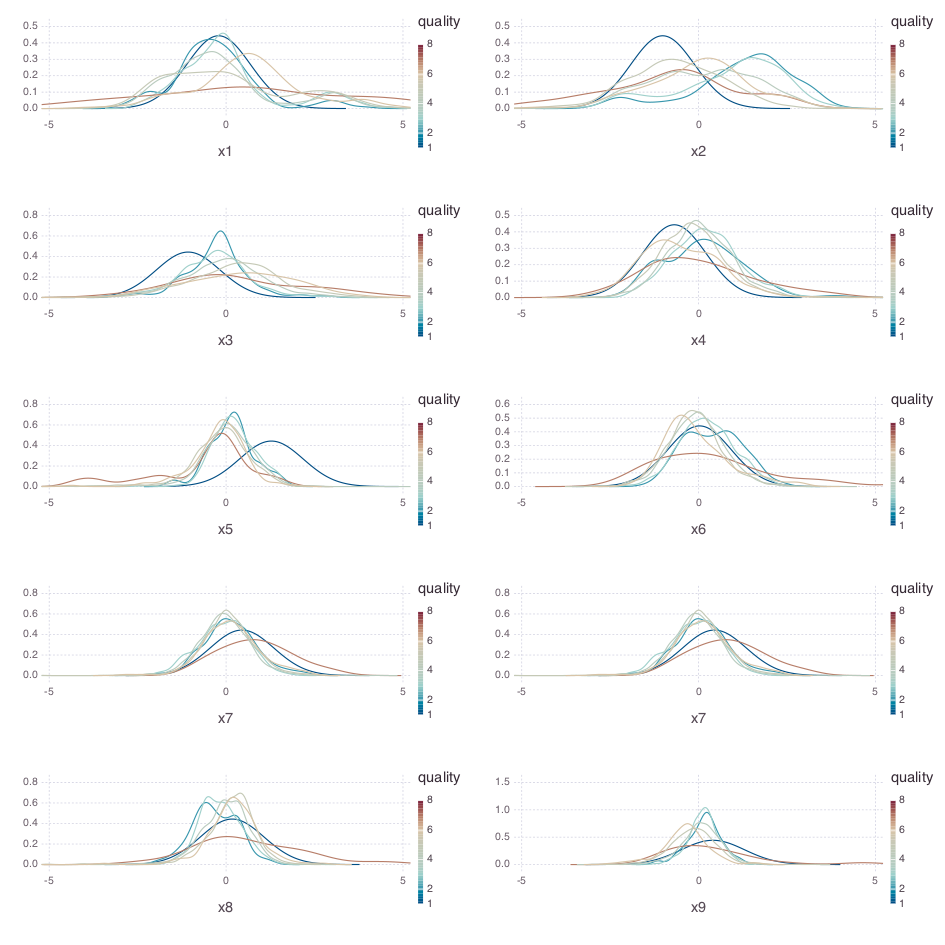

In [118]:
filename = "quality_pca_density_all"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[7]),
    hstack(plots[8], plots[9]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

In [119]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6, :x7, :x8, :x9, :x10]
df_pca_labelled_stacked = stack(df_pca_labelled, variables)

for variable in variables
    feature = df_pca_labelled_stacked[df_pca_labelled_stacked[:variable].==variable, :]     
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end

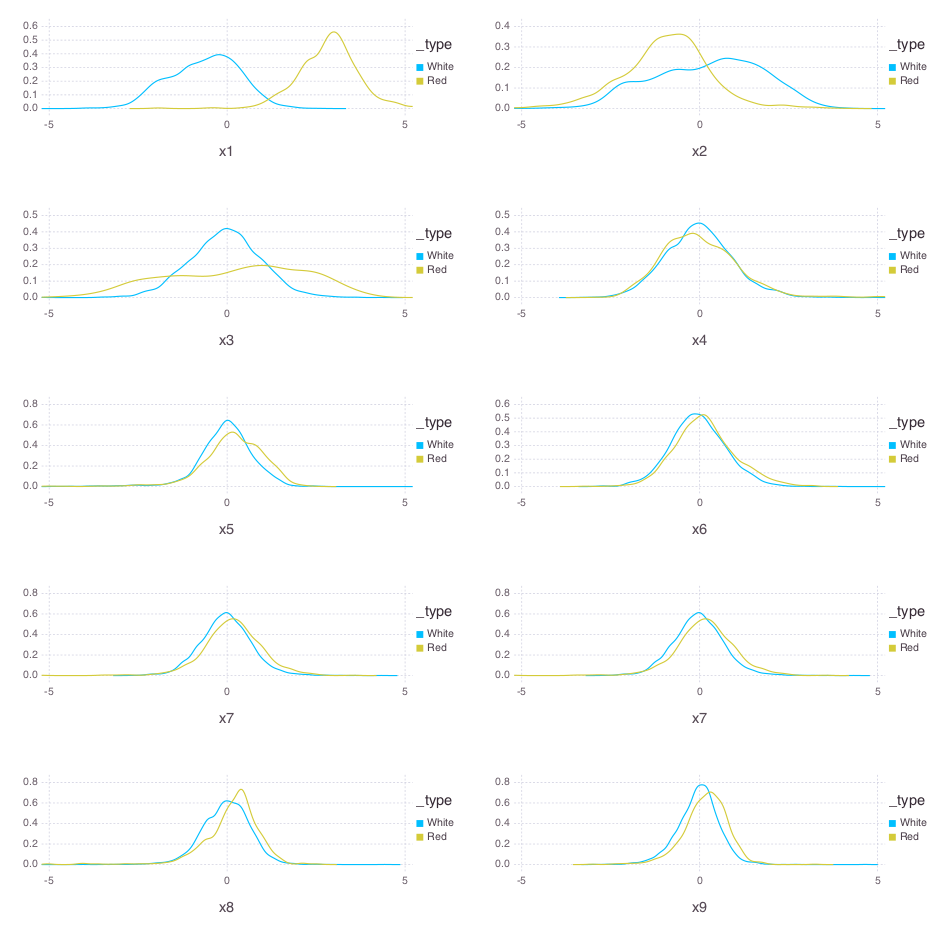

In [120]:
filename = "type_pca_density_all"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[7]),
    hstack(plots[8], plots[9]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

# ICA

In [121]:
# train a CCA model
M = fit(ICA, feature_matrix, 6)
ica_matrix = transform(M, feature_matrix)';

LoadError: LoadError: UndefVarError: feature_matrix not defined
while loading In[121], in expression starting on line 2

In [122]:
df_ica = DataFrame(ica_matrix)
labels = df_train[:,12:13]
df_ica_labelled = hcat(df_ica, labels)
head(df_ica_labelled,1)

LoadError: LoadError: UndefVarError: ica_matrix not defined
while loading In[122], in expression starting on line 1

In [123]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
for variable in variables
    push!(plots, plot(df_ica_labelled, color=:_type, x=variable, Geom.density,
        Guide.xlabel(string(variable), orientation=:horizontal)))
end

LoadError: LoadError: UndefVarError: df_ica_labelled not defined
while loading In[123], in expression starting on line 4

In [124]:
filename = "density_ica"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

LoadError: LoadError: BoundsError: attempt to access 0-element Array{Gadfly.Plot,1}
  at index [1]
while loading In[124], in expression starting on line 2

# Linear regression

# Logistic regression

Let's implement logistic regression from scratch to start simple:

$g(x) =  \sum_{i=0}^k w_i Φ_i(x)$, with $Φ_0(x) = 0$

# Neural Network

### Backpropagation:

Number of features is the size of the training set columns, without the id, type and quality columns

In [125]:
num_of_features = size(df_train,2)-3

10

Specify the architechture. We'll have a fully connected MLP with 1 hidden layer.

In [126]:
hidden_layers = 1;
hidden_units = 20;
num_of_outputs = 1;

Initialize the weight matrices randomly

In [127]:
using Distributions 
θ1 = rand(Uniform(-1, 1), hidden_units + 1, num_of_features + 1);
θ1[1, :] = 1;
θ1

21x11 Array{Float64,2}:
  1.0         1.0          1.0        …   1.0         1.0         1.0     
 -0.291348    0.847963     0.704455       0.631471    0.0172367   0.388353
 -0.31529    -0.0407083   -0.774871       0.70891    -0.316949    0.563322
  0.267577    0.45639      0.0831547      0.272098    0.790575    0.422013
  0.64238     0.320801    -0.743263      -0.853513   -0.279192    0.637241
  0.87716    -0.865528     0.997103   …  -0.359006    0.0101999  -0.654156
 -0.0534648   0.00297708  -0.435026      -0.0113118   0.702171    0.159966
  0.721104    0.543953    -0.148574       0.99104    -0.415686   -0.543941
 -0.628936    0.802641    -0.163513       0.38988    -0.261744    0.343741
  0.324137   -0.436328     0.14117        0.561936    0.44149     0.525539
 -0.689323    0.0569495   -0.310655   …   0.14224    -0.575313   -0.739579
  0.969091   -0.190524    -0.710002      -0.702384   -0.0255898  -0.487185
 -0.871134   -0.577161     0.58533       -0.352187    0.521884    0.932845
 

In [128]:
θ2 = rand(Uniform(-1, 1), num_of_outputs, hidden_units + 1);

In [129]:
size(θ1), size(θ2)

((21,11),(1,21))

In [130]:
x = rand(10)

10-element Array{Float64,1}:
 0.067439
 0.915163
 0.883824
 0.38847 
 0.716562
 0.556956
 0.967748
 0.887471
 0.364477
 0.402827

In [131]:
x = [1;x]

11-element Array{Float64,1}:
 1.0     
 0.067439
 0.915163
 0.883824
 0.38847 
 0.716562
 0.556956
 0.967748
 0.887471
 0.364477
 0.402827

In [132]:
tanh(θ1 * x)

21-element Array{Float64,1}:
  0.999999 
  0.568519 
 -0.96035  
  0.991828 
  0.0874592
  0.946774 
 -0.716616 
  0.874111 
 -0.867046 
  0.952395 
 -0.891699 
 -0.906986 
  0.234395 
  0.810573 
  0.676122 
  0.664599 
 -0.118373 
 -0.844737 
 -0.305473 
  0.997734 
 -0.964194 

In [133]:
function forwardprop(x,θ)
    tanh(θ ⋅ x)
end

forwardprop (generic function with 1 method)